## Run FIrst

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torchvision import datasets
from torchsummary import summary
import random
#Neural Networks
import torch.nn as nn
import torch.nn.functional as F
#Visualize img
from torchvision.utils import make_grid
import time
#PLotting
import pylab as pl
#Optimizer
import torch.optim as optim
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [5]:
def get_device():
    return torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
get_device()
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [6]:
from matplotlib.markers import MarkerStyle
class Basenet(nn.Module):


    def set_loss_function(self,learning_rt,optimizer_fn,mm):
        criterion = nn.CrossEntropyLoss()
        if optimizer_fn == "SGD":
            optimizer = optim.SGD(self.parameters(), lr=learning_rt, momentum=mm)
        elif optimizer_fn == "Adam":
            optimizer = optim.Adam(self.parameters(), lr=learning_rt)
        return criterion,optimizer
    
    
    
    def train_model(self,epochs,learning_rt=0.001,optimizer_fn = "SGD",mm=0.9):
        start = time.time()
        train_stats = []
        self.criterion,self.optimizer = self.set_loss_function(learning_rt,optimizer_fn,mm)
        criterion = self.criterion
        optimizer = self.optimizer
        self.epoch = epochs
        self.stats = []
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
        early_stopper = EarlyStopper(patience=2, min_delta=1)
        for epoch in range(epochs):  # loop over the dataset multiple times
            self.train()
            running_loss = 0.0
            train_loss = []
            train_acc = []
            for i, train_set in enumerate(self.trainloader, 0):# get the inputs; data is a list of [inputs, labels]
                #inputs, labels = data
                inputs, labels = train_set[0].to(get_default_device()), train_set[1].to(get_default_device())
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                torch.autograd.set_detect_anomaly(True)
                #Appending sample loss to list
#                 train_loss.append(loss.item())
                
#                 # print statistics
#                 running_loss += loss.item()
#                 if i % 2000 == 1999:    # print every 2000 mini-batches
#                     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
# #                     print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item() / 2000:.3f}')
#                     running_loss = 0.0
            # self.train()
            train_acc,train_loss = self.acc_and_loss(self.trainloader)
            # self.eval()
            val_acc,val_loss = self.acc_and_loss(self.valloader,"val")
            if early_stopper.early_stop(val_loss):  
              break
            # scheduler.step(val_loss)
            train_stat = {"epoch" : epoch+1,"Train_Loss" :train_loss,"Train_Acc" :train_acc,"Val_Acc": val_acc,"Val_Loss":val_loss}
            print(train_stat)
            # train_stats.append(train_stat)
            # train_stat = {"epoch" : epoch,"Train_Loss" :train_loss,"Train_Acc" :train_acc,"Val_Acc": val_acc,"Val_Loss":val_loss}
            # print(train_stat)
            train_stats.append(train_stat)
            # self.stats=train_stats
            # if epoch>0:
            #   print("went here at: ",epoch)
            #   if (epoch<epoch-1):
            #     print("if went here at: ",epoch)
            #     self.plot_graph(epoch)
            #   else:
            #     print("else went here at: ",epoch)
            #     self.plot_graph(epoch,last_plot= True)
        self.stats=train_stats
        print('Finished Training')
        print(f"Time taken for execution: {round((time.time() - start)/60,2)} minutes")
#         return True

#-==--------------------------------------------Testing
    def goog_train_model(self,epochs,learning_rt=0.001,optimizer_fn = "SGD",mm=0.9):
                start = time.time()
                train_stats = []
                self.criterion,self.optimizer = self.set_loss_function(learning_rt,optimizer_fn,mm)
                criterion = self.criterion
                optimizer = self.optimizer
                self.epoch = epochs
                self.stats = []
                early_stopper = EarlyStopper(patience=2, min_delta=1)
                for epoch in range(epochs):  # loop over the dataset multiple times
                    self.train()
                    running_loss = 0.0
                    train_loss = []
                    train_acc = []
                    for i, train_set in enumerate(self.trainloader, 0):# get the inputs; data is a list of [inputs, labels]
                        #inputs, labels = data
                        inputs, labels = train_set[0].to(get_default_device()), train_set[1].to(get_default_device())
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        # forward + backward + optimize
                        outputs = self(inputs)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        torch.autograd.set_detect_anomaly(True)

                    self.epoch = (epoch+1)
                    train_acc,train_loss = self.acc_and_loss(self.trainloader)
                    # self.eval()
                    val_acc,val_loss = self.acc_and_loss(self.valloader,"val")
                    if early_stopper.early_stop(val_loss):  
                      break
                    # scheduler.step(val_loss)
                    train_stat = {"epoch" : epoch+1,"Train_Loss" :train_loss,"Train_Acc" :train_acc,"Val_Acc": val_acc,"Val_Loss":val_loss}
                    print(train_stat)

                    train_stats.append(train_stat)

                self.stats=train_stats
                print('Finished Training')
                print(f"Time taken for execution: {round((time.time() - start)/60,2)} minutes")
#         return True
##_--------------------------------------------------------------------------------------------------------------------------------------------

    def imshow(self,img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        # plt.show()
    def acc_and_loss(self,loader,flag = 'train'):
        self.eval()
        losses = []
        acc_lst = []
        mean_loss,acc = 0,0
        lbl_sz =0
        criterion = self.criterion
        optimizer = self.optimizer
        #NO gradient required as not training
        with torch.no_grad():
            for i, data in enumerate(loader, 0):
                # get the inputs
                inputs, labels = data[0].to(get_default_device()), data[1].to(get_default_device())
                outputs = self(inputs)
                #Accuracy
                lbl_sz+=labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                itm = (predicted == labels).sum().item()
                acc_lst.append(itm)
                #losses
                loss = criterion(outputs, labels)
                losses.append(loss.item())
        mean_loss = np.mean(losses)
        acc=(100 * np.sum(acc_lst) / lbl_sz)
        return  acc,mean_loss
    def Accuracy(self,flag):
        if flag == 'val':
          loader = self.valloader
        else:
          loader = self.testloader
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in loader:
                images, labels = data[0].to(get_default_device()), data[1].to(get_default_device())
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Accuracy of the network on the {len(loader)} images: %d %%' % (
            100 * correct / total))
        return (100 * correct / total)
    
    # def Testing(self,flag):
    #     dataiter = iter(loader)
    #     images, labels = dataiter.next()
    #     # print images
    #     self.imshow(self,torchvision.utils.make_grid(images))
    #     print('GroundTruth: ', ' '.join(f'{self.classes[labels[j]]:5s}' for j in range(4)))

    def class_Acc(self,flag='val'):
        if flag == 'val':
          loader = self.valloader
        else:
          loader = self.testloader
        self.eval()
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        with torch.no_grad():
            for data in loader:
                images, labels = data[0].to(get_default_device()), data[1].to(get_default_device())
                outputs = self(images)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == labels).squeeze()
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
        for i in range(10):
            print('Accuracy of %5s : %2d %%' % (
                self.classes[i], 100 * class_correct[i] / class_total[i]))
            
    # # helper function to un-normalize and display an image        
    def show_image(self,loader):
        img, label = loader
        print('Label: ', self.classes[label], "("+str(label)+")")
        plt.imshow(img.permute(1,2,0))

    # def show_prediction(self, loader):
    #     index = random.randint(0,len(loader))
    #     fig = plt.figure(figsize=(25, 4))
    #     images, labels = data[0].to(get_default_device()), data[1].to(get_default_device())


        
    def show_graph(self):
        train_accuracies = [x['Train_Acc'] for x in self.stats]
        val_accuracies = [x['Val_Acc'] for x in self.stats]  
        train_losses = [x['Train_Loss'] for x in self.stats]
        val_losses = [x['Val_Loss'] for x in self.stats] 
        #Loss Graph
        plt.figure(figsize=(5, 4))
        plt.title("Plotting Training/Validation Loss vs Epochs")
        plt.plot(np.arange(self.epoch), val_losses, label = "Validation Loss")
        plt.plot(np.arange(self.epoch), train_losses, label = "Training Loss")
        plt.legend()
        plt.show()
        #Accuracy Graph
        plt.figure(figsize=(5, 4))
        plt.title("Plotting Training/Validation Accuracy  vs Epochs")
        plt.plot(np.arange(self.epoch), val_accuracies, label = "Validation Accuracy")
        plt.plot(np.arange(self.epoch), train_accuracies, label = "Training Accuracy")
        plt.legend()
        plt.show()

    def plot_graph(self,x,last_plot= False):
      train_accuracies = [x['Train_Acc'] for x in self.stats]
      val_accuracies = [x['Val_Acc'] for x in self.stats]  
      train_losses = [x['Train_Loss'] for x in self.stats]
      val_losses = [x['Val_Loss'] for x in self.stats] 
      x = np.arange(x)
      pl.close()
      pl.figure(figsize=(5, 4))
      markersize = 4
      # if last_plot:
      #   pl.xlim(min(x),max(x)+0.2)
      # else:
      #   pl.xlim(min(x),self.epoch+0.2)
      # pl.ylim((0,2))
      print(x,train_accuracies)
      pl.plot(x,train_accuracies,color = 'red',linestyle = '--',marker = 'x',markersize = markersize)
      pl.plot(x,val_accuracies,color = 'blue',linestyle = '--',marker = 'x',markersize = markersize)
      pl.plot(x,train_losses,color = 'green',linestyle = '--',marker = 'x',markersize = markersize)
      pl.plot(x,val_losses,color = 'yellow',linestyle = '--',marker = 'x',markersize = markersize)
      pl.grid(color ='black',linestyle='--',linewidth=0.5)
      pl.legend(['Training Accuracy','Validation Accuracy','Training Loss','Validaion Loss'])
      pl.xlabel('Epochs')
      pl.title('Stats Visual')
      display.clear_output(wait=True)
      display.display(pl.gcf())
      time.sleep(0.1)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



Show Images in datset

## Images

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000


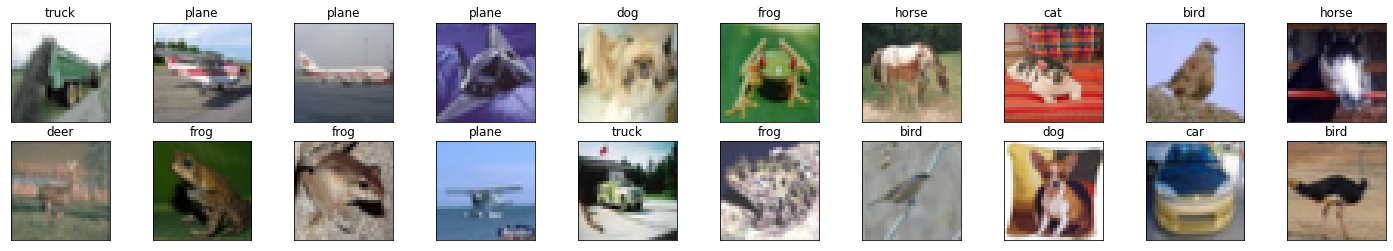

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
shimg = Imagenet_model1()


# def imshow(img):
#     img = img / 2 + 0.5  # unnormalize
#     plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
# # obtain one batch of training images
dataiter = iter(shimg.trainloader)
images, labels = dataiter.next()
# images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  shimg.imshow(images[idx])
  ax.set_title(shimg.classes[labels[idx]])

Model 1 - Basic CNN/FCNN structure 

In [8]:
class Imagenet_model1(Basenet):
    def __init__(self,dataset="CIFAR10",batch=32,path='./data',splitsize = .2):
        super().__init__()
        torch.manual_seed(42)
        self.shapes = False
        #CNN Layer 1
        self.conv1 = nn.Conv2d(3, 6, 5)
        # self.batchnorm1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        #CNN Layer 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        # self.batchnorm2 = nn.BatchNorm2d(16)
        #FCNN Layer 1
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #FCNN Layer 2
        self.fc2 = nn.Linear(120, 84)
        # self.batchnorm3 = nn.BatchNorm1d(84)
        #FCNN LAyer 3
        self.fc3 = nn.Linear(84, 10)
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        

        # #Regularization Parameters
        # self.dropout2d = nn.Dropout2d()
        # self.dropout1d = nn.Dropout1d()

        self.criterion = None
        self.optimizer = None
        self.stats = []
        self.epoch = 0
        if dataset== "CIFAR10":
            batch_size = batch
            dataset = torchvision.datasets.CIFAR10(root=path, train=True,
                                                    download=True, transform=transform)
            val_size = int(len(dataset)*splitsize)
            train_size = len(dataset) - val_size
            train_set, valid_set = data.random_split(dataset, [train_size, val_size])
            self.train_set = train_set
            self.trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Training Size :",len(train_set))
            
            self.valloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Validation Size :",len(valid_set))
            testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                                  download=True, transform=transform)
            print("Testing Size :",len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat',
                      'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    def forward(self, x):
        if self.shapes:
            print("Initial x shape ", x.shape)

        #CNN Layer 1
        x = self.conv1(x)
        # x = self.batchnorm1(x)
        x = F.relu(x)
        if self.shapes:
            print('After conv1, shape of x is ', x.shape)
        x = self.pool(x)
        if self.shapes:
            print('After conv1, shape of x is ', x.shape)
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.dropout2d(x)

        #CNN Layer 2
        x = self.conv2(x)
        # x = self.batchnorm2(x)
        x = F.relu(x)
        if self.shapes:
            print('After conv2, shape of x is ', x.shape)
        x = self.pool(x)
        if self.shapes:
            print('After conv2, shape of x is ', x.shape)
        # x = self.dropout2d(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch

        #FCNN Layer 1
        x = self.fc1(x)
        x = F.relu(x)
        # x = self.dropout1d(x)

        #FCNN Layer 2
        x = self.fc2(x)
        # x = self.batchnorm3(x)
        x = F.relu(x)
        
        #LAst Linear Layer
        x = self.fc3(x)
        return x
# !nvidia-smi
temp = Imagenet_model1().to(get_default_device())
summary(temp, (3, 32, 32))

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
------------------------------

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
{'epoch': 1, 'Train_Loss': 1.431345713710785, 'Train_Acc': 47.7475, 'Val_Acc': 46.64, 'Val_Loss': 1.4603600385851754}
{'epoch': 2, 'Train_Loss': 1.235739415884018, 'Train_Acc': 55.8175, 'Val_Acc': 53.47, 'Val_Loss': 1.297682420514262}
{'epoch': 3, 'Train_Loss': 1.107749252462387, 'Train_Acc': 60.5275, 'Val_Acc': 57.03, 'Val_Loss': 1.20935238150362}
{'epoch': 4, 'Train_Loss': 0.9988309779644012, 'Train_Acc': 65.14, 'Val_Acc': 59.29, 'Val_Loss': 1.1519908855517451}
{'epoch': 5, 'Train_Loss': 0.9688296221494674, 'Train_Acc': 65.4275, 'Val_Acc': 58.87, 'Val_Loss': 1.1776102318550452}
Finished Training
Time taken for execution: 2.8260941465695697 minutes


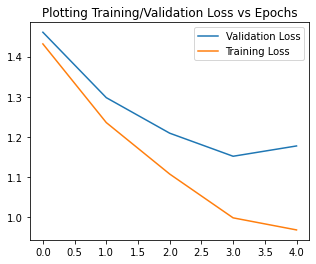

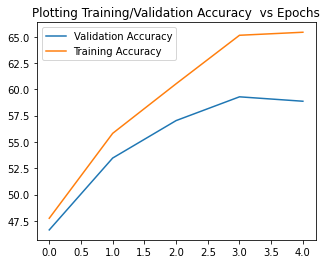

In [ ]:
#BAtch 20 2 Batch Norms 1-CNN(on 2nd one), 1-FCNN,1 dropout - 2nd cnn
model1 = Imagenet_model1()
model1=model1.to(get_default_device())
#train_model(self,epochs,learning_rt=0.001,optimizer_fn = "SGD",mm=0.9)
model1.train_model(5,0.01,"SGD",mm=0.9)
model1.show_graph()# batch - 4|'Train_Acc': 39.9925, 'Val_Acc': 39.25||batch 15 'Train_Acc': 47.38, 'Val_Acc': 46.93,|| batch -32 'Train_Acc': 49.2825, 'Val_Acc': 47.89 ||

In [ ]:
model1.class_Acc("val")
# model1.Accuracy("val")

Accuracy of plane : 57 %
Accuracy of   car : 80 %
Accuracy of  bird : 52 %
Accuracy of   cat : 43 %
Accuracy of  deer : 60 %
Accuracy of   dog : 50 %
Accuracy of  frog : 64 %
Accuracy of horse : 48 %
Accuracy of  ship : 77 %
Accuracy of truck : 64 %


Hyper Parameter tuning

In [ ]:
model1_tuning = Imagenet_model1()
model1_tuning=model1_tuning.to(get_default_device())
for i in ["SGD" , "Adam"]:
  for j in [1,.1,.01,.001,.001]:
    print(f"For combination of {i} and {j}")
    model1_tuning.train_model(3,j,i)
    print("-----------------------------")

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
For combination of SGD and 1
{'epoch': 1, 'Train_Loss': 2.3819122499465943, 'Train_Acc': 10.0025, 'Val_Acc': 9.99, 'Val_Loss': 2.3864462010014935}
{'epoch': 2, 'Train_Loss': 2.376842329597473, 'Train_Acc': 10.0025, 'Val_Acc': 9.99, 'Val_Loss': 2.3777795310218495}
{'epoch': 3, 'Train_Loss': 2.3416931852340697, 'Train_Acc': 10.0325, 'Val_Acc': 9.87, 'Val_Loss': 2.346088417802756}
Finished Training
Time taken for execution: 1.65 minutes
-----------------------------
For combination of SGD and 0.1
{'epoch': 1, 'Train_Loss': 2.310490088844299, 'Train_Acc': 9.96, 'Val_Acc': 10.16, 'Val_Loss': 2.3123392548423984}
{'epoch': 2, 'Train_Loss': 2.3082942596435547, 'Train_Acc': 9.96, 'Val_Acc': 10.16, 'Val_Loss': 2.3100647286485176}
{'epoch': 3, 'Train_Loss': 2.3070869899749757, 'Train_Acc': 10.0025, 'Val_Acc': 9.99, 'Val_Loss': 2.3094763816735995}
Finished 

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
For lr :1
{'epoch': 1, 'Train_Loss': 2.3819123571395875, 'Train_Acc': 10.0025, 'Val_Acc': 9.99, 'Val_Loss': 2.3864463114509946}
{'epoch': 2, 'Train_Loss': 2.376842381477356, 'Train_Acc': 10.0025, 'Val_Acc': 9.99, 'Val_Loss': 2.3777795790102534}
{'epoch': 3, 'Train_Loss': 2.3416931066513063, 'Train_Acc': 10.0325, 'Val_Acc': 9.87, 'Val_Loss': 2.34608834620101}
Finished Training
Time taken for execution: 1.61 minutes
-----------------------------
For lr :0.1
{'epoch': 1, 'Train_Loss': 2.310490027999878, 'Train_Acc': 9.96, 'Val_Acc': 10.16, 'Val_Loss': 2.312339195428184}
{'epoch': 2, 'Train_Loss': 2.3082942596435547, 'Train_Acc': 9.96, 'Val_Acc': 10.16, 'Val_Loss': 2.3100647286485176}
{'epoch': 3, 'Train_Loss': 2.307087060165405, 'Train_Acc': 10.0025, 'Val_Acc': 9.99, 'Val_Loss': 2.3094764631777145}
Finished Training
Time taken for execution: 1.61 m

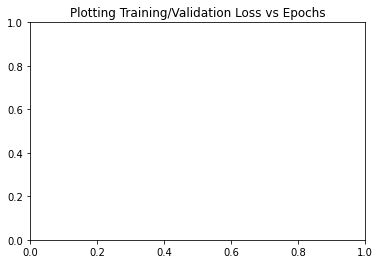

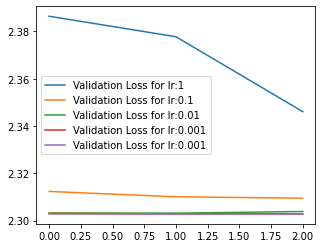

In [11]:
model1_tuning_v2 = Imagenet_model1()
model1_tuning_v2=model1_tuning_v2.to(get_default_device())
plt.title("Plotting Training/Validation Loss vs Epochs")
plt.figure(figsize=(5, 4))
for j in [1,.1,.01,.001,.001]:
    print(f"For lr :{j}")
    model1_tuning_v2.train_model(3,j)
    train_losses = [x['Train_Loss'] for x in model1_tuning_v2.stats]
    val_losses = [x['Val_Loss'] for x in model1_tuning_v2.stats] 
    #Loss Graph
    plt.plot(np.arange(model1_tuning_v2.epoch), val_losses, label = f"Validation Loss for lr:{j}")
    # plt.plot(np.arange(model1_tuning_v2.epoch), train_losses, label = "Training Loss")  
    print("-----------------------------")
plt.legend()
plt.show()  

MOdel 2

In [ ]:
class Imagenet_model2(Basenet):
    def __init__(self,dataset="CIFAR10",batch=15,path='./data',splitsize = .2):
        super().__init__()
        torch.manual_seed(42)

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.batchnorm1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.batchnorm3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.batchnorm4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(dim=1)
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        

        #Regularization Parameters
        self.dropout2d = nn.Dropout2d()
        self.dropout1d = nn.Dropout1d()

        self.criterion = None
        self.optimizer = None
        self.stats = []
        self.epoch = 0
        if dataset== "CIFAR10":
            batch_size = batch
            dataset = torchvision.datasets.CIFAR10(root=path, train=True,
                                                    download=True, transform=transform)
#             trainset = torchvision.datasets.CIFAR10(root=path, train=True,
#                                                     download=True, transform=transform)
            val_size = int(len(dataset)*splitsize)
            train_size = len(dataset) - val_size
            train_set, valid_set = data.random_split(dataset, [train_size, val_size])
            self.train_set = train_set
            self.trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Training Size :",len(train_set))
            
            self.valloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Validation Size :",len(valid_set))
            testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                                  download=True, transform=transform)
            print("Testing Size :",len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat',
                      'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    def forward(self, x):
        #CNN Layer 1
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = self.pool(x)
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.dropout2d(x)

        #CNN Layer 2
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = self.pool(x)
        # x = self.dropout2d(x)


        #FCNN layer 1
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        # x = self.dropout1d(x)

        #FCNN layer 2
        x = self.fc2(x)
        x = self.batchnorm4(x)
        x = F.relu(x)

        #FCNN layer 3
        x = self.fc3(x)

        #Linear Layer
        x = self.softmax(x)
        return x
temp = Imagenet_model2().to(get_default_device())
summary(temp, (3, 32, 32))

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
       BatchNorm2d-2            [-1, 6, 28, 28]              12
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
       BatchNorm2d-5           [-1, 16, 10, 10]              32
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
       BatchNorm1d-8                  [-1, 120]             240
            Linear-9                   [-1, 84]          10,164
      BatchNorm1d-10                   [-1, 84]             168
           Linear-11                   [-1, 10]             850
          Softmax-12    

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
[1,  2000] loss: 2.095
{'epoch': 1, 'Train_Loss': 2.0130076564828867, 'Train_Acc': 44.6, 'Val_Acc': 46.63, 'Val_Loss': 1.9927214065949241}
[2,  2000] loss: 2.029
{'epoch': 2, 'Train_Loss': 2.010159116896253, 'Train_Acc': 45.0475, 'Val_Acc': 47.43, 'Val_Loss': 1.987169023217826}
[3,  2000] loss: 1.961
{'epoch': 3, 'Train_Loss': 1.956036312954677, 'Train_Acc': 50.56, 'Val_Acc': 53.07, 'Val_Loss': 1.931226103023432}
[4,  2000] loss: 1.923
{'epoch': 4, 'Train_Loss': 1.9426818433485542, 'Train_Acc': 51.78, 'Val_Acc': 53.93, 'Val_Loss': 1.921392457238559}
[5,  2000] loss: 1.896
{'epoch': 5, 'Train_Loss': 1.9230023865669374, 'Train_Acc': 53.645, 'Val_Acc': 56.05, 'Val_Loss': 1.9001765624694023}
Finished Training
Time taken for execution: 5.22 minutes


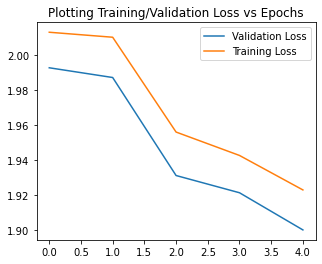

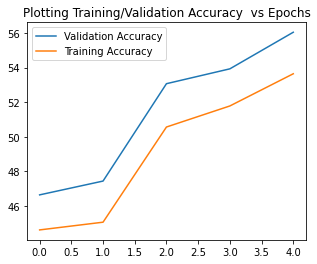

In [ ]:
#Just adding SOftmax
model2 = Imagenet_model2()
model2=model2.to(get_default_device())
model2.train_model(5,0.01,"SGD",mm=0.9)
model2.show_graph()


In [ ]:
model2.class_Acc("val")
# model2.Accuracy("val")

Accuracy of plane : 57 %
Accuracy of   car : 73 %
Accuracy of  bird : 40 %
Accuracy of   cat : 41 %
Accuracy of  deer : 51 %
Accuracy of   dog : 35 %
Accuracy of  frog : 80 %
Accuracy of horse : 58 %
Accuracy of  ship : 74 %
Accuracy of truck : 56 %


In [ ]:
class Imagenet_model3(Basenet):
    def __init__(self,dataset="CIFAR10",batch=15,path='./data',splitsize = .2):
        super().__init__()
        torch.manual_seed(42)
        self.shapes = False
        #CNN Layer 1
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        #CNN Layer 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        #FCNN Layer 1
        self.fc1 = nn.Linear(16 * 5 * 5, 120)

        #FCNN Layer 2
        self.fc2 = nn.Linear(120, 84)

        #FCNN LAyer 3
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(dim=1)
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        

        # #Regularization Parameters
        self.dropout2d = nn.Dropout2d(.2)
        self.dropout1d = nn.Dropout1d(.5)

        self.criterion = None
        self.optimizer = None
        self.stats = []
        self.epoch = 0
        if dataset== "CIFAR10":
            batch_size = batch
            dataset = torchvision.datasets.CIFAR10(root=path, train=True,
                                                    download=True, transform=transform)
            val_size = int(len(dataset)*splitsize)
            train_size = len(dataset) - val_size
            train_set, valid_set = data.random_split(dataset, [train_size, val_size])
            self.train_set = train_set
            self.trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Training Size :",len(train_set))
            
            self.valloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Validation Size :",len(valid_set))
            testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                                  download=True, transform=transform)
            print("Testing Size :",len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat',
                      'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    def forward(self, x):

        #CNN Layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.dropout2d(x)

        #CNN Layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        # x = self.dropout2d(x)

        # flatten all dimensions except batch
        x = torch.flatten(x, 1) 

        #FCNN Layer 1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1d(x)

        #FCNN Layer 2
        x = self.fc2(x)
        # x = self.batchnorm3(x)
        x = F.relu(x)
        # x = self.dropout1d(x)
        #LAst Linear Layer
        x = self.fc3(x)
        x = self.softmax(x)
        return x
# !nvidia-smi
temp = Imagenet_model3().to(get_default_device())
summary(temp, (3, 32, 32))

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
         Dropout1d-6                  [-1, 120]               0
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
           Softmax-9                   [-1, 10]               0
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
[1,  2000] loss: 2.279
{'epoch': 1, 'Train_Loss': 2.251258196346224, 'Train_Acc': 17.245, 'Val_Acc': 24.3, 'Val_Loss': 2.204483209342613}
[2,  2000] loss: 2.112
{'epoch': 2, 'Train_Loss': 2.1834431013723057, 'Train_Acc': 24.585, 'Val_Acc': 38.46, 'Val_Loss': 2.068140426139603}
[3,  2000] loss: 2.075
{'epoch': 3, 'Train_Loss': 2.2075887568040784, 'Train_Acc': 22.3225, 'Val_Acc': 34.89, 'Val_Loss': 2.1082152753755605}
[4,  2000] loss: 2.100
{'epoch': 4, 'Train_Loss': 2.2502298235759155, 'Train_Acc': 18.235, 'Val_Acc': 26.16, 'Val_Loss': 2.1991941660776666}
[5,  2000] loss: 2.229
{'epoch': 5, 'Train_Loss': 2.311773111143495, 'Train_Acc': 12.0775, 'Val_Acc': 13.52, 'Val_Loss': 2.3258575406567803}
Finished Training
Time taken for execution: 4.72 minutes


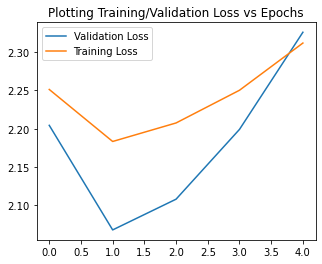

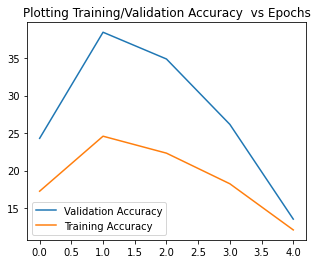

In [ ]:
#Batch - 256 | Sgd |Lr = 0.005
model3 = Imagenet_model3()
model3=model3.to(get_default_device())
model3.train_model(5,0.01,"SGD")
model3.show_graph()

In [ ]:
model3.class_Acc("val")
# model3.Accuracy("val")

Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog : 97 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship : 37 %
Accuracy of truck :  0 %


In [13]:
class Imagenet_model4(Basenet):
    def __init__(self,dataset="CIFAR10",batch=32,path='./data',splitsize = .2):
        super().__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.batchnorm4 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=.5)
        self.criterion = None
        self.optimizer = None
        self.stats = []
        self.epoch = 0
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        if dataset== "CIFAR10":
            batch_size = batch
            dataset = torchvision.datasets.CIFAR10(root=path, train=True,
                                                    download=True, transform=transform)
            val_size = int(len(dataset)*splitsize)
            train_size = len(dataset) - val_size
            train_set, valid_set = data.random_split(dataset, [train_size, val_size])
            self.train_set = train_set
            self.trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Training Size :",len(train_set))
            
            self.valloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Validation Size :",len(valid_set))
            testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                                  download=True, transform=transform)
            print("Testing Size :",len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat',
                      'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        # flattening
        x = x.view(-1, 64 * 4 * 4)
        # fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.batchnorm4(self.fc2(x)))
        x = self.fc3(x)
        return x
temp = Imagenet_model4().to(get_default_device())
summary(temp, (3, 32, 32))

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
       BatchNorm2d-8             [-1, 64, 8, 8]             128
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                  [-1, 512]         524,800
          Dropout-11                  [-1, 512]               0
           Linear-12    

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
{'epoch': 1, 'Train_Loss': 1.3606168121337892, 'Train_Acc': 51.48, 'Val_Acc': 54.0, 'Val_Loss': 1.2931431177706003}
{'epoch': 2, 'Train_Loss': 1.2634221166610717, 'Train_Acc': 56.2475, 'Val_Acc': 61.02, 'Val_Loss': 1.175097268800766}
{'epoch': 3, 'Train_Loss': 1.1596992571830749, 'Train_Acc': 60.8425, 'Val_Acc': 66.16, 'Val_Loss': 1.0654076625363895}
{'epoch': 4, 'Train_Loss': 1.10308639421463, 'Train_Acc': 62.9325, 'Val_Acc': 68.03, 'Val_Loss': 1.0073841307490778}
{'epoch': 5, 'Train_Loss': 1.075480207157135, 'Train_Acc': 63.5125, 'Val_Acc': 70.01, 'Val_Loss': 0.93983544080783}
{'epoch': 6, 'Train_Loss': 1.0728325622081756, 'Train_Acc': 63.5125, 'Val_Acc': 70.32, 'Val_Loss': 0.9257764854370215}
{'epoch': 7, 'Train_Loss': 1.0706021363258362, 'Train_Acc': 63.435, 'Val_Acc': 71.66, 'Val_Loss': 0.9069137681787387}
{'epoch': 8, 'Train_Loss': 1.07774

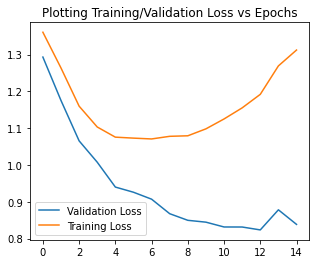

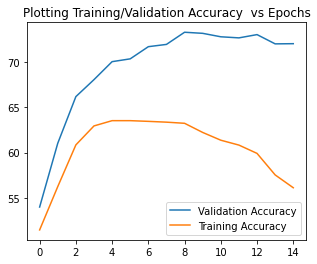

Accuracy of plane : 57 %
Accuracy of   car : 86 %
Accuracy of  bird : 66 %
Accuracy of   cat : 36 %
Accuracy of  deer : 75 %
Accuracy of   dog : 54 %
Accuracy of  frog : 85 %
Accuracy of horse : 78 %
Accuracy of  ship : 89 %
Accuracy of truck : 69 %
----------------------------------
Testing : 
Test Acc :  71.72
Test Acc :  0.843623432298057
Accuracy of plane : 59 %
Accuracy of   car : 88 %
Accuracy of  bird : 66 %
Accuracy of   cat : 37 %
Accuracy of  deer : 59 %
Accuracy of   dog : 61 %
Accuracy of  frog : 86 %
Accuracy of horse : 81 %
Accuracy of  ship : 88 %
Accuracy of truck : 77 %


In [ ]:
model4 = Imagenet_model4()
model4=model4.to(get_default_device())
model4.train_model(15,0.001,"SGD")
model4.show_graph()
model4.class_Acc("val")
print("----------------------------------")
print("Testing : ")
tst_a,tst_l = model4.acc_and_loss(model4.testloader,flag = 'test')
print("Test Acc : ",tst_a)
print("Test Acc : ",tst_l)
model4.class_Acc("test")

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
{'epoch': 1, 'Train_Loss': 1.2252383244514464, 'Train_Acc': 55.485, 'Val_Acc': 58.21, 'Val_Loss': 1.1426083316056492}
{'epoch': 2, 'Train_Loss': 1.0891725447654723, 'Train_Acc': 61.45, 'Val_Acc': 64.16, 'Val_Loss': 1.012862192270474}
{'epoch': 3, 'Train_Loss': 0.9799183086395263, 'Train_Acc': 65.61, 'Val_Acc': 67.71, 'Val_Loss': 0.9263760291349393}
{'epoch': 4, 'Train_Loss': 0.9559398812532425, 'Train_Acc': 66.5625, 'Val_Acc': 69.54, 'Val_Loss': 0.8822133770575539}
{'epoch': 5, 'Train_Loss': 0.9748327540636063, 'Train_Acc': 66.1475, 'Val_Acc': 69.24, 'Val_Loss': 0.8982950837467425}
{'epoch': 6, 'Train_Loss': 1.0351250727653503, 'Train_Acc': 65.135, 'Val_Acc': 68.04, 'Val_Loss': 0.9439534697288903}
{'epoch': 7, 'Train_Loss': 1.113600019288063, 'Train_Acc': 63.2825, 'Val_Acc': 65.14, 'Val_Loss': 1.0409791010637253}
{'epoch': 8, 'Train_Loss': 1.144

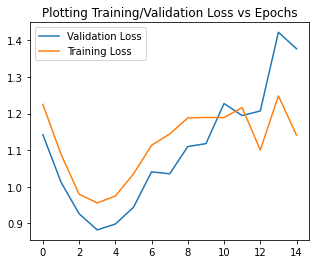

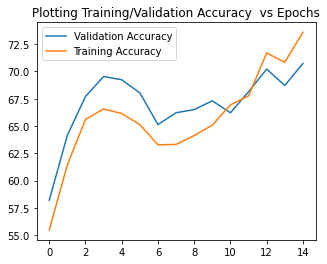

Accuracy of plane : 70 %
Accuracy of   car : 78 %
Accuracy of  bird : 70 %
Accuracy of   cat : 61 %
Accuracy of  deer : 73 %
Accuracy of   dog : 52 %
Accuracy of  frog : 76 %
Accuracy of horse : 68 %
Accuracy of  ship : 80 %
Accuracy of truck : 70 %
----------------------------------
Testing : 
Test Acc :  70.4
Test Acc :  1.3530374772061173
Accuracy of plane : 73 %
Accuracy of   car : 80 %
Accuracy of  bird : 51 %
Accuracy of   cat : 56 %
Accuracy of  deer : 79 %
Accuracy of   dog : 58 %
Accuracy of  frog : 74 %
Accuracy of horse : 60 %
Accuracy of  ship : 89 %
Accuracy of truck : 75 %


In [ ]:
model4 = Imagenet_model4()
model4=model4.to(get_default_device())
model4.train_model(15,0.01,"SGD")
model4.show_graph()
model4.class_Acc("val")
print("----------------------------------")
print("Testing : ")
tst_a,tst_l = model4.acc_and_loss(model4.testloader,flag = 'test')
print("Test Acc : ",tst_a)
print("Test Acc : ",tst_l)
model4.class_Acc("test")

Tuning Lr for model 4

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
For lr :0.01
{'epoch': 1, 'Train_Loss': 1.1218251955986023, 'Train_Acc': 60.09, 'Val_Acc': 59.39, 'Val_Loss': 1.1320330432047858}
{'epoch': 2, 'Train_Loss': 0.8830771343708038, 'Train_Acc': 68.735, 'Val_Acc': 67.08, 'Val_Loss': 0.9236855131749528}
{'epoch': 3, 'Train_Loss': 0.7402325129270554, 'Train_Acc': 74.26, 'Val_Acc': 71.04, 'Val_Loss': 0.8240854026029666}
{'epoch': 4, 'Train_Loss': 0.7477487121343612, 'Train_Acc': 73.63, 'Val_Acc': 70.22, 'Val_Loss': 0.8487813194719748}
{'epoch': 5, 'Train_Loss': 0.6098244086384773, 'Train_Acc': 78.94, 'Val_Acc': 73.46, 'Val_Loss': 0.7558977854328034}
{'epoch': 6, 'Train_Loss': 0.5265299992561341, 'Train_Acc': 81.835, 'Val_Acc': 75.14, 'Val_Loss': 0.7056490792253147}
{'epoch': 7, 'Train_Loss': 0.4923409232497215, 'Train_Acc': 83.1775, 'Val_Acc': 75.68, 'Val_Loss': 0.7036439243216104}
{'epoch': 8, 'Train_L

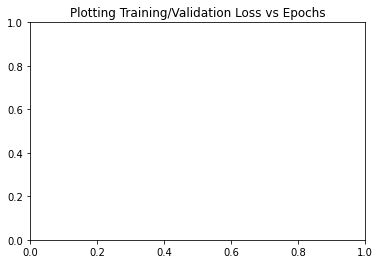

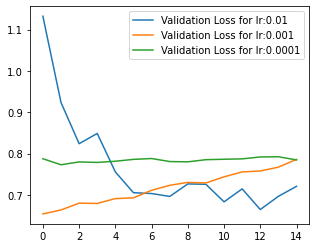

In [19]:
model4_tuning  = Imagenet_model4()
model4_tuning=model4_tuning.to(get_default_device())
plt.title("Plotting Training/Validation Loss vs Epochs")
plt.figure(figsize=(5, 4))
for j in [.01,.001,.0001]:
    print(f"For lr :{j}")
    model4_tuning.train_model(15,j)
    # train_losses = [x['Train_Loss'] for x in model4_tuning.stats]
    val_losses = [x['Val_Loss'] for x in model4_tuning.stats] 
    #Loss Graph
    plt.plot(np.arange(model4_tuning.epoch), val_losses, label = f"Validation Loss for lr:{j}")
    # plt.plot(np.arange(model1_tuning_v2.epoch), train_losses, label = "Training Loss")  
    print("-----------------------------")
plt.legend()
plt.show() 

Tuning optimizer for model 4

In [ ]:
model4_tuning_opt = Imagenet_model4()
model4_tuning=model4_tuning.to(get_default_device())
plt.title("Plotting Training/Validation Loss vs Epochs")
plt.figure(figsize=(5, 4))
for j in [.01,.001,.0001]:
    print(f"For lr :{j}")
    model4_tuning.train_model(15,j)
    # train_losses = [x['Train_Loss'] for x in model4_tuning.stats]
    val_losses = [x['Val_Loss'] for x in model4_tuning.stats] 
    #Loss Graph
    plt.plot(np.arange(model4_tuning.epoch), val_losses, label = f"Validation Loss for lr:{j}")
    # plt.plot(np.arange(model1_tuning_v2.epoch), train_losses, label = "Training Loss")  
    print("-----------------------------")
plt.legend()
plt.show() 

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
{'epoch': 1, 'Train_Loss': 1.1177031944751739, 'Train_Acc': 60.5175, 'Val_Acc': 63.13, 'Val_Loss': 1.039673637277402}
{'epoch': 2, 'Train_Loss': 0.998745055770874, 'Train_Acc': 65.08, 'Val_Acc': 67.29, 'Val_Loss': 0.9545712446252378}
{'epoch': 3, 'Train_Loss': 0.9113226403713226, 'Train_Acc': 68.1925, 'Val_Acc': 70.81, 'Val_Loss': 0.8452553841443108}
{'epoch': 4, 'Train_Loss': 0.8917509726285935, 'Train_Acc': 68.54, 'Val_Acc': 71.15, 'Val_Loss': 0.8316729503889053}
{'epoch': 5, 'Train_Loss': 0.8507729744434357, 'Train_Acc': 69.675, 'Val_Acc': 72.83, 'Val_Loss': 0.7811946508983454}
{'epoch': 6, 'Train_Loss': 0.9069168082952499, 'Train_Acc': 68.1675, 'Val_Acc': 71.66, 'Val_Loss': 0.8068872330287775}
{'epoch': 7, 'Train_Loss': 0.9063570625066757, 'Train_Acc': 68.785, 'Val_Acc': 72.12, 'Val_Loss': 0.79829111028784}
{'epoch': 8, 'Train_Loss': 0.99880

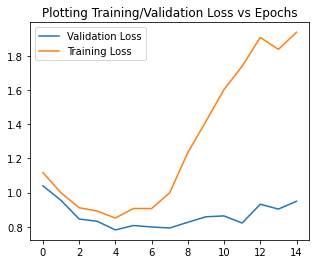

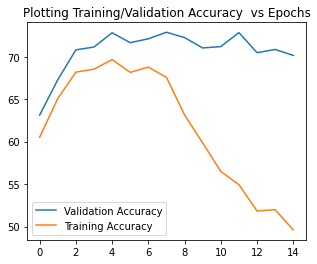

Accuracy of plane : 69 %
Accuracy of   car : 72 %
Accuracy of  bird : 59 %
Accuracy of   cat : 74 %
Accuracy of  deer : 77 %
Accuracy of   dog : 42 %
Accuracy of  frog : 68 %
Accuracy of horse : 74 %
Accuracy of  ship : 89 %
Accuracy of truck : 81 %
----------------------------------
Testing : 
Test Acc :  69.51
Test Acc :  0.9588433125148565
Accuracy of plane : 66 %
Accuracy of   car : 68 %
Accuracy of  bird : 59 %
Accuracy of   cat : 76 %
Accuracy of  deer : 75 %
Accuracy of   dog : 50 %
Accuracy of  frog : 73 %
Accuracy of horse : 70 %
Accuracy of  ship : 88 %
Accuracy of truck : 76 %


In [ ]:
model4 = Imagenet_model4()
model4=model4.to(get_default_device())
model4.train_model(15,0.001,"Adam")
model4.show_graph()
model4.class_Acc("val")
print("----------------------------------")
print("Testing : ")
tst_a,tst_l = model4.acc_and_loss(model4.testloader,flag = 'test')
print("Test Acc : ",tst_a)
print("Test Acc : ",tst_l)
model4.class_Acc("test")

Awesome MOdel  from https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844

class CNN(nn.Module):


Resnet -18 Transfer Learning

In [ ]:
from torchvision import models
from torchvision.models import ResNet18_Weights
class resnet_18(Basenet):
    def __init__(self,dataset="CIFAR10",batch=15,path='./data',splitsize = .2):
        super().__init__()
        torch.manual_seed(42)
        self.network = models.resnet18(pretrained=True)
        
        # transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),
        #                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        # transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(), transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
        self.criterion = None
        self.optimizer = None
        self.stats = []
        self.epoch = 0
        if dataset== "CIFAR10":
            batch_size = batch
            dataset = torchvision.datasets.CIFAR10(root=path, train=True,
                                                    download=True, transform=ResNet18_Weights.DEFAULT.transforms())
            val_size = int(len(dataset)*splitsize)
            train_size = len(dataset) - val_size
            train_set, valid_set = data.random_split(dataset, [train_size, val_size])
            self.train_set = train_set
            self.trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Training Size :",len(train_set))
            
            self.valloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Validation Size :",len(valid_set))
            testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                                  download=True, transform=ResNet18_Weights.DEFAULT.transforms())
            print("Testing Size :",len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat',
                      'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    def forward(self,x):
      return self.network(x)
temp = resnet_18().to(get_default_device())
summary(temp, (3, 32, 32))
# print(temp)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12    

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
[1,  2000] loss: 0.708
{'epoch': 1, 'Train_Loss': 0.2785770934128196, 'Train_Acc': 90.5, 'Val_Acc': 90.39, 'Val_Loss': 0.28211839508120046}
[2,  2000] loss: 0.339
{'epoch': 2, 'Train_Loss': 0.21728050003713817, 'Train_Acc': 92.585, 'Val_Acc': 91.7, 'Val_Loss': 0.2561472625753701}
[3,  2000] loss: 0.193
{'epoch': 3, 'Train_Loss': 0.16760131701118866, 'Train_Acc': 94.1975, 'Val_Acc': 93.05, 'Val_Loss': 0.21489384346385032}
[4,  2000] loss: 0.121
{'epoch': 4, 'Train_Loss': 0.14348820733342701, 'Train_Acc': 95.0225, 'Val_Acc': 93.22, 'Val_Loss': 0.21762226152817077}
[5,  2000] loss: 0.084
{'epoch': 5, 'Train_Loss': 0.1352189707766619, 'Train_Acc': 95.265, 'Val_Acc': 93.35, 'Val_Loss': 0.21870665500737205}
Finished Training
Time taken for execution: 32.28 minutes


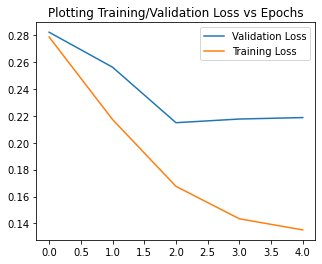

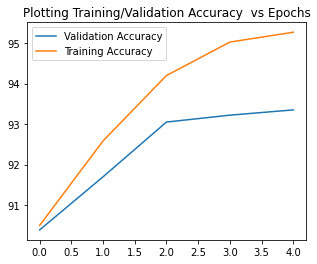

Accuracy of plane : 90 %
Accuracy of   car : 97 %
Accuracy of  bird : 91 %
Accuracy of   cat : 82 %
Accuracy of  deer : 95 %
Accuracy of   dog : 90 %
Accuracy of  frog : 97 %
Accuracy of horse : 94 %
Accuracy of  ship : 96 %
Accuracy of truck : 95 %
----------------------------------
Testing : 
Test Acc :  93.01
Test Acc :  0.21768893850035267
Accuracy of plane : 91 %
Accuracy of   car : 97 %
Accuracy of  bird : 92 %
Accuracy of   cat : 82 %
Accuracy of  deer : 94 %
Accuracy of   dog : 91 %
Accuracy of  frog : 98 %
Accuracy of horse : 96 %
Accuracy of  ship : 97 %
Accuracy of truck : 97 %


In [ ]:
model_resnet = resnet_18()
# num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(512, 10)
model_resnet=model_resnet.to(get_default_device())
model_resnet.train_model(5,0.001,"SGD")
model_resnet.show_graph()
model_resnet.class_Acc("val")
print("----------------------------------")
print("Testing : ")
tst_a,tst_l = model_resnet.acc_and_loss(model_resnet.testloader,flag = 'test')
print("Test Acc : ",tst_a)
print("Test Acc : ",tst_l)
model_resnet.class_Acc("test")

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
[1,  2000] loss: 1.069
{'epoch': 1, 'Train_Loss': 0.6478610290071246, 'Train_Acc': 77.7275, 'Val_Acc': 78.61, 'Val_Loss': 0.6272636092808294}
[2,  2000] loss: 0.736
{'epoch': 2, 'Train_Loss': 0.6307645753350068, 'Train_Acc': 81.31, 'Val_Acc': 80.75, 'Val_Loss': 0.6576304289880955}
[3,  2000] loss: 0.517
{'epoch': 3, 'Train_Loss': 0.7251946633293342, 'Train_Acc': 77.685, 'Val_Acc': 79.36, 'Val_Loss': 0.674764372324613}
[4,  2000] loss: 0.397
{'epoch': 4, 'Train_Loss': 0.5423556952354895, 'Train_Acc': 82.0775, 'Val_Acc': 81.06, 'Val_Loss': 0.6047100654287987}
[5,  2000] loss: 0.312
{'epoch': 5, 'Train_Loss': 0.5768625158530231, 'Train_Acc': 81.4275, 'Val_Acc': 79.75, 'Val_Loss': 0.6743219164625994}
Finished Training
Time taken for execution: 18.62 minutes


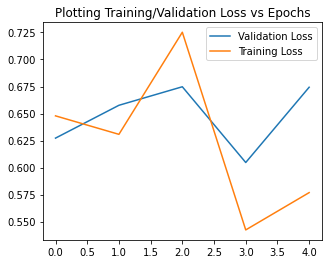

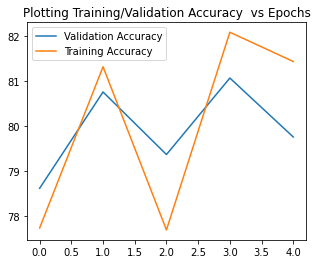

Accuracy of plane : 83 %
Accuracy of   car : 94 %
Accuracy of  bird : 59 %
Accuracy of   cat : 65 %
Accuracy of  deer : 90 %
Accuracy of   dog : 72 %
Accuracy of  frog : 89 %
Accuracy of horse : 70 %
Accuracy of  ship : 90 %
Accuracy of truck : 82 %
----------------------------------
Testing : 
Test Acc :  79.94
Test Acc :  0.6765484689990396
Accuracy of plane : 86 %
Accuracy of   car : 90 %
Accuracy of  bird : 60 %
Accuracy of   cat : 60 %
Accuracy of  deer : 91 %
Accuracy of   dog : 80 %
Accuracy of  frog : 91 %
Accuracy of horse : 71 %
Accuracy of  ship : 86 %
Accuracy of truck : 84 %


In [ ]:
model_resnet_A = resnet_18()
# num_ftrs = model_resnet.fc.in_features
model_resnet_A.fc = nn.Linear(512, 10)
model_resnet_A=model_resnet_A.to(get_default_device())
model_resnet_A.train_model(5,0.001,"Adam")
model_resnet_A.show_graph()
model_resnet_A.class_Acc("val")
print("----------------------------------")
print("Testing : ")
tst_a,tst_l = model_resnet_A.acc_and_loss(model_resnet_A.testloader,flag = 'test')
print("Test Acc : ",tst_a)
print("Test Acc : ",tst_l)
model_resnet_A.class_Acc("test")

vgg 16 

In [7]:
from torchvision import models
from torchvision.models import VGG16_Weights
class vgg_16(Basenet):
    def __init__(self,dataset="CIFAR10",batch=15,path='./data',splitsize = .2):
        super().__init__()
        torch.manual_seed(42)
        self.network = models.vgg16(pretrained=True)
        
        # transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),
        #                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        # transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(), transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
        self.criterion = None
        self.optimizer = None
        self.stats = []
        self.epoch = 0
        if dataset== "CIFAR10":
            batch_size = batch
            dataset = torchvision.datasets.CIFAR10(root=path, train=True,
                                                    download=True, transform=VGG16_Weights.DEFAULT.transforms())
            val_size = int(len(dataset)*splitsize)
            train_size = len(dataset) - val_size
            train_set, valid_set = data.random_split(dataset, [train_size, val_size])
            self.train_set = train_set
            self.trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Training Size :",len(train_set))
            
            self.valloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Validation Size :",len(valid_set))
            testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                                  download=True, transform=VGG16_Weights.DEFAULT.transforms())
            print("Testing Size :",len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat',
                      'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    def forward(self,x):
      return self.network(x)
temp = vgg_16().to(get_default_device())
summary(temp, (3, 32, 32))
# print(temp)

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12    

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
[1,  2000] loss: 0.973
{'epoch': 1, 'Train_Loss': 0.39987548397882605, 'Train_Acc': 86.1175, 'Val_Acc': 84.55, 'Val_Loss': 0.4397046554392424}
[2,  2000] loss: 0.318
{'epoch': 2, 'Train_Loss': 0.23290874388840302, 'Train_Acc': 91.965, 'Val_Acc': 88.28, 'Val_Loss': 0.3448428362817399}
[3,  2000] loss: 0.182
{'epoch': 3, 'Train_Loss': 0.15297260817020214, 'Train_Acc': 94.6175, 'Val_Acc': 89.31, 'Val_Loss': 0.3288802587168188}
[4,  2000] loss: 0.104
{'epoch': 4, 'Train_Loss': 0.11440888365902538, 'Train_Acc': 96.1125, 'Val_Acc': 89.29, 'Val_Loss': 0.3507083214378205}
[5,  2000] loss: 0.070
{'epoch': 5, 'Train_Loss': 0.07160749911695609, 'Train_Acc': 97.4975, 'Val_Acc': 90.37, 'Val_Loss': 0.3504278399380545}
Finished Training
Time taken for execution: 18.38 minutes


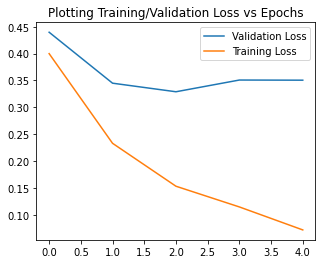

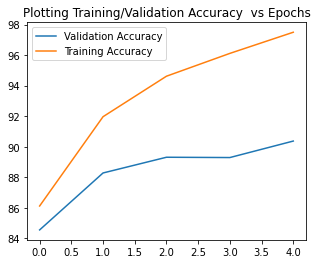

Accuracy of plane : 91 %
Accuracy of   car : 99 %
Accuracy of  bird : 87 %
Accuracy of   cat : 82 %
Accuracy of  deer : 86 %
Accuracy of   dog : 89 %
Accuracy of  frog : 96 %
Accuracy of horse : 89 %
Accuracy of  ship : 97 %
Accuracy of truck : 87 %
----------------------------------
Testing : 
Test Acc :  89.98
Test Acc :  0.36103893111451535
Accuracy of plane : 92 %
Accuracy of   car : 97 %
Accuracy of  bird : 87 %
Accuracy of   cat : 83 %
Accuracy of  deer : 90 %
Accuracy of   dog : 86 %
Accuracy of  frog : 94 %
Accuracy of horse : 87 %
Accuracy of  ship : 97 %
Accuracy of truck : 87 %


In [ ]:
model_vgg16 = vgg_16()
# num_ftrs = model_resnet.fc.in_features
model_vgg16.fc = nn.Linear(512, 10)
model_vgg16=model_vgg16.to(get_default_device())
model_vgg16.train_model(5,0.001,"SGD")
model_vgg16.show_graph()
model_vgg16.class_Acc("val")
print("----------------------------------")
print("Testing : ")
tst_a,tst_l = model_vgg16.acc_and_loss(model_vgg16.testloader,flag = 'test')
print("Test Acc : ",tst_a)
print("Test Acc : ",tst_l)
model_vgg16.class_Acc("test")

In [ ]:
model_vgg16_A = vgg_16()
# num_ftrs = model_resnet.fc.in_features
model_vgg16_A.fc = nn.Linear(512, 10)
model_vgg16_A=model_vgg16_A.to(get_default_device())
model_vgg16_A.train_model(5,0.0001,"Adam")
model_vgg16_A.show_graph()
model_vgg16_A.class_Acc("val")
print("----------------------------------")
print("Testing : ")
tst_a,tst_l = model_vgg16_A.acc_and_loss(model_vgg16_A.testloader,flag = 'test')
print("Test Acc : ",tst_a)
print("Test Acc : ",tst_l)
model_vgg16_A.class_Acc("test")

Google Net

In [ ]:
from torchvision import models
from torchvision.models import GoogLeNet_Weights
class GoogleNet(Basenet):
    def __init__(self,dataset="CIFAR10",batch=15,path='./data',splitsize = .2):
        super().__init__()
        torch.manual_seed(42)
        self.network = models.googlenet(pretrained=True)

        
        # transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),
        #                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        # transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(), transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
        self.criterion = None
        self.optimizer = None
        self.stats = []
        self.epoch = 0
        if dataset== "CIFAR10":
            batch_size = batch
            dataset = torchvision.datasets.CIFAR10(root=path, train=True,
                                                    download=True, transform=GoogLeNet_Weights.DEFAULT.transforms())
            val_size = int(len(dataset)*splitsize)
            train_size = len(dataset) - val_size
            train_set, valid_set = data.random_split(dataset, [train_size, val_size])
            self.train_set = train_set
            self.trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Training Size :",len(train_set))
            
            self.valloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Validation Size :",len(valid_set))
            testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                                  download=True, transform=GoogLeNet_Weights.DEFAULT.transforms())
            print("Testing Size :",len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat',
                      'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    def forward(self,x):
      return self.network(x)
temp = GoogleNet().to(get_default_device())
summary(temp, (3, 32, 32))
# print(temp)

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
       BasicConv2d-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
       BasicConv2d-7             [-1, 64, 8, 8]               0
            Conv2d-8            [-1, 192, 8, 8]         110,592
       BatchNorm2d-9            [-1, 192, 8, 8]             384
      BasicConv2d-10            [-1, 192, 8, 8]               0
        MaxPool2d-11            [-1, 192, 4, 4]               0
           Conv2d-12    

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
{'epoch': 1, 'Train_Loss': 0.4829729278133655, 'Train_Acc': 84.5075, 'Val_Acc': 82.54, 'Val_Loss': 0.542078059641407}
{'epoch': 2, 'Train_Loss': 0.29939037573568866, 'Train_Acc': 90.495, 'Val_Acc': 87.42, 'Val_Loss': 0.3718137156212705}
{'epoch': 3, 'Train_Loss': 0.21734113197837948, 'Train_Acc': 93.2175, 'Val_Acc': 90.11, 'Val_Loss': 0.3039643709335582}
{'epoch': 4, 'Train_Loss': 0.18007301532862102, 'Train_Acc': 94.34, 'Val_Acc': 90.69, 'Val_Loss': 0.28163558386986715}
{'epoch': 5, 'Train_Loss': 0.13936838764141382, 'Train_Acc': 95.735, 'Val_Acc': 91.49, 'Val_Loss': 0.25152231431447497}
{'epoch': 6, 'Train_Loss': 0.1142497169839328, 'Train_Acc': 96.71, 'Val_Acc': 91.87, 'Val_Loss': 0.24175980260995017}
{'epoch': 7, 'Train_Loss': 0.09304247721125251, 'Train_Acc': 97.355, 'Val_Acc': 92.23, 'Val_Loss': 0.22872268984574584}
{'epoch': 8, 'Train_Los

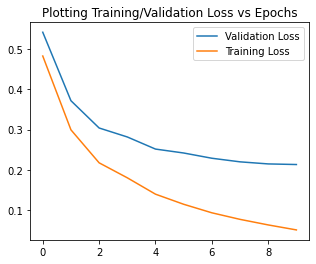

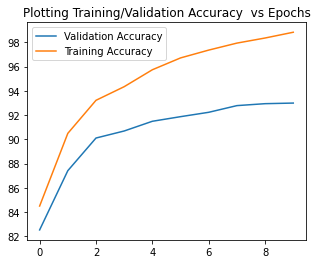

Accuracy of plane : 95 %
Accuracy of   car : 96 %
Accuracy of  bird : 93 %
Accuracy of   cat : 87 %
Accuracy of  deer : 93 %
Accuracy of   dog : 86 %
Accuracy of  frog : 95 %
Accuracy of horse : 92 %
Accuracy of  ship : 92 %
Accuracy of truck : 96 %
----------------------------------
Testing : 
Test Acc :  93.15
Test Acc :  0.2091391964414474
Accuracy of plane : 94 %
Accuracy of   car : 93 %
Accuracy of  bird : 93 %
Accuracy of   cat : 86 %
Accuracy of  deer : 92 %
Accuracy of   dog : 90 %
Accuracy of  frog : 96 %
Accuracy of horse : 92 %
Accuracy of  ship : 96 %
Accuracy of truck : 97 %


In [ ]:
model_googleNet = GoogleNet()
# num_ftrs = model_resnet.fc.in_features
model_googleNet.fc = nn.Linear(1024, 10)
model_googleNet=model_googleNet.to(get_default_device())
model_googleNet.train_model(10,0.0001,"SGD")
model_googleNet.show_graph()
model_googleNet.class_Acc("val")
print("----------------------------------")
print("Testing : ")
tst_a,tst_l = model_googleNet.acc_and_loss(model_googleNet.testloader,flag = 'test')
print("Test Acc : ",tst_a)
print("Test Acc : ",tst_l)
model_googleNet.class_Acc("test")

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
[1,  2000] loss: 0.926
{'epoch': 1, 'Train_Loss': 0.5675057269602086, 'Train_Acc': 80.6475, 'Val_Acc': 81.5, 'Val_Loss': 0.5356812054763312}
[2,  2000] loss: 0.760
{'epoch': 2, 'Train_Loss': 0.5875955048182376, 'Train_Acc': 81.27, 'Val_Acc': 83.24, 'Val_Loss': 0.5208799637396118}
[3,  2000] loss: 0.533
{'epoch': 3, 'Train_Loss': 0.6893406119456017, 'Train_Acc': 79.1825, 'Val_Acc': 80.58, 'Val_Loss': 0.6194440038844027}
[4,  2000] loss: 0.433
{'epoch': 4, 'Train_Loss': 0.7642209351650832, 'Train_Acc': 75.915, 'Val_Acc': 79.74, 'Val_Loss': 0.6459280547003138}
[5,  2000] loss: 0.368
{'epoch': 5, 'Train_Loss': 1.0084028445340674, 'Train_Acc': 73.3525, 'Val_Acc': 75.42, 'Val_Loss': 0.9115100776583984}
Finished Training
Time taken for execution: 38.62 minutes


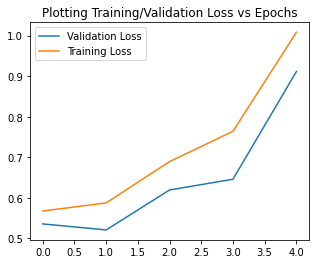

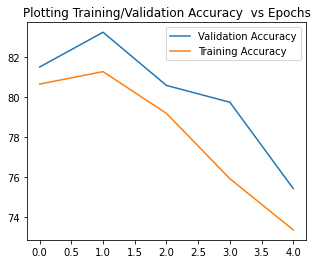

Accuracy of plane : 24 %
Accuracy of   car : 97 %
Accuracy of  bird : 92 %
Accuracy of   cat : 84 %
Accuracy of  deer : 71 %
Accuracy of   dog : 49 %
Accuracy of  frog : 79 %
Accuracy of horse : 78 %
Accuracy of  ship : 80 %
Accuracy of truck : 95 %
----------------------------------
Testing : 
Test Acc :  75.52
Test Acc :  0.8928503036677748
Accuracy of plane : 30 %
Accuracy of   car : 96 %
Accuracy of  bird : 94 %
Accuracy of   cat : 83 %
Accuracy of  deer : 71 %
Accuracy of   dog : 55 %
Accuracy of  frog : 79 %
Accuracy of horse : 75 %
Accuracy of  ship : 80 %
Accuracy of truck : 94 %


In [ ]:
model_googleNet_A = GoogleNet()
# num_ftrs = model_resnet.fc.in_features
model_googleNet_A.fc = nn.Linear(512, 10)
model_googleNet_A=model_googleNet_A.to(get_default_device())
model_googleNet_A.train_model(5,0.001,"Adam")
model_googleNet_A.show_graph()
model_googleNet_A.class_Acc("val")
print("----------------------------------")
print("Testing : ")
tst_a,tst_l = model_googleNet_A.acc_and_loss(model_googleNet_A.testloader,flag = 'test')
print("Test Acc : ",tst_a)
print("Test Acc : ",tst_l)
model_googleNet_A.class_Acc("test")

Hyper-parameter tuning in GoogleNet

using lr:0.01&op:SGD
Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
{'epoch': 1, 'Train_Loss': 0.3065622641244379, 'Train_Acc': 89.1225, 'Val_Acc': 85.9, 'Val_Loss': 0.4031697079941429}
{'epoch': 2, 'Train_Loss': 0.21545967560938592, 'Train_Acc': 92.39, 'Val_Acc': 87.91, 'Val_Loss': 0.3578461350812374}
{'epoch': 3, 'Train_Loss': 0.14615219887448172, 'Train_Acc': 94.95, 'Val_Acc': 89.21, 'Val_Loss': 0.3239376307601274}
{'epoch': 4, 'Train_Loss': 0.10975681440699143, 'Train_Acc': 96.0225, 'Val_Acc': 89.82, 'Val_Loss': 0.3372758510569669}
Finished Training
Time taken for execution: 29.33 minutes


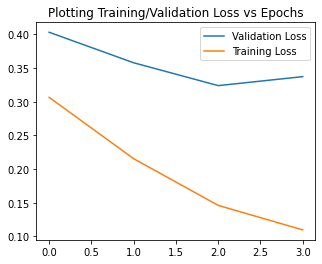

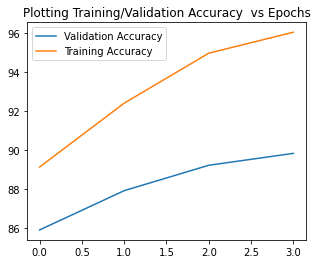

----------------------------------
using lr:0.01&op:Adam


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
{'epoch': 1, 'Train_Loss': 1.240110547054471, 'Train_Acc': 54.035, 'Val_Acc': 53.49, 'Val_Loss': 1.258212684959486}
{'epoch': 2, 'Train_Loss': 1.166716768203445, 'Train_Acc': 59.4375, 'Val_Acc': 57.68, 'Val_Loss': 1.2067624258583989}
{'epoch': 3, 'Train_Loss': 0.7588097013569433, 'Train_Acc': 73.63, 'Val_Acc': 70.8, 'Val_Loss': 0.8417250965086596}
{'epoch': 4, 'Train_Loss': 0.6839743491735716, 'Train_Acc': 76.445, 'Val_Acc': 72.08, 'Val_Loss': 0.795072700286555}
Finished Training
Time taken for execution: 31.27 minutes


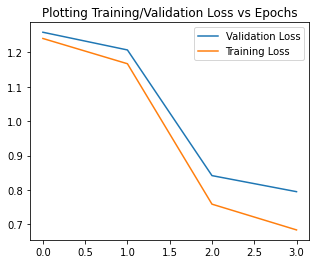

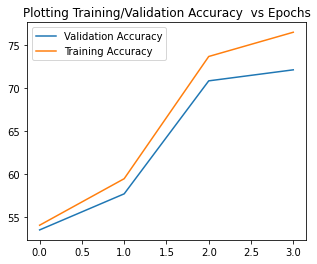

----------------------------------
using lr:0.001&op:SGD


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
{'epoch': 1, 'Train_Loss': 0.18719672003104781, 'Train_Acc': 93.805, 'Val_Acc': 90.78, 'Val_Loss': 0.2713996232633871}
{'epoch': 2, 'Train_Loss': 0.09370959409976844, 'Train_Acc': 97.0175, 'Val_Acc': 92.64, 'Val_Loss': 0.21749215969617577}
{'epoch': 3, 'Train_Loss': 0.05306822973661691, 'Train_Acc': 98.46, 'Val_Acc': 93.59, 'Val_Loss': 0.19510062791164853}
{'epoch': 4, 'Train_Loss': 0.03453204494687202, 'Train_Acc': 98.9775, 'Val_Acc': 93.19, 'Val_Loss': 0.20734981294324994}
Finished Training
Time taken for execution: 29.37 minutes


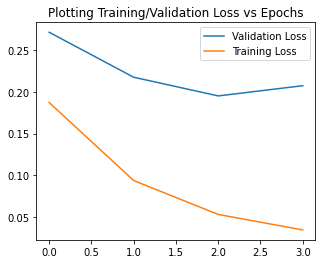

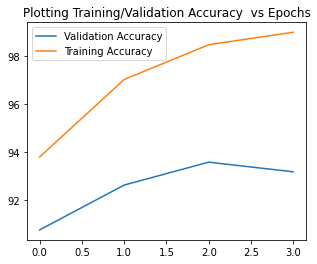

----------------------------------
using lr:0.001&op:Adam


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
{'epoch': 1, 'Train_Loss': 0.5329157117339368, 'Train_Acc': 81.7125, 'Val_Acc': 79.04, 'Val_Loss': 0.6074525471190284}
{'epoch': 2, 'Train_Loss': 0.39356745902485907, 'Train_Acc': 86.39, 'Val_Acc': 82.89, 'Val_Loss': 0.509845817017591}
{'epoch': 3, 'Train_Loss': 0.27811907985473605, 'Train_Acc': 90.4, 'Val_Acc': 86.53, 'Val_Loss': 0.3998355829496233}
{'epoch': 4, 'Train_Loss': 0.2358623144703449, 'Train_Acc': 91.805, 'Val_Acc': 86.97, 'Val_Loss': 0.3846161706970706}
Finished Training
Time taken for execution: 31.14 minutes


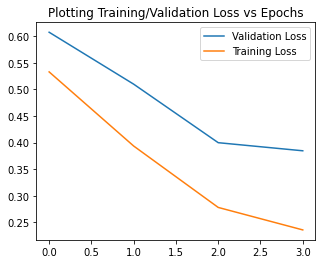

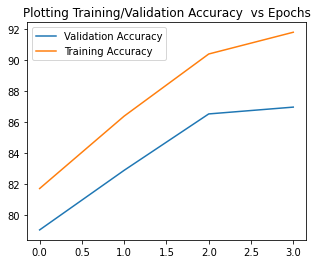

----------------------------------
using lr:0.0001&op:SGD


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
{'epoch': 1, 'Train_Loss': 0.48297065272536177, 'Train_Acc': 84.515, 'Val_Acc': 82.55, 'Val_Loss': 0.5420680808006734}
{'epoch': 2, 'Train_Loss': 0.29955632974860547, 'Train_Acc': 90.44, 'Val_Acc': 87.26, 'Val_Loss': 0.378561334502974}
{'epoch': 3, 'Train_Loss': 0.21744260005094182, 'Train_Acc': 93.0375, 'Val_Acc': 90.06, 'Val_Loss': 0.30626402664831887}
{'epoch': 4, 'Train_Loss': 0.1721524556014997, 'Train_Acc': 94.445, 'Val_Acc': 90.69, 'Val_Loss': 0.276932955325778}
Finished Training
Time taken for execution: 28.9 minutes


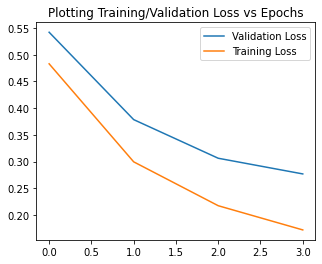

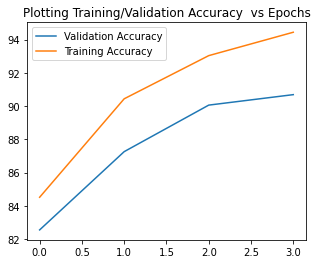

----------------------------------
using lr:0.0001&op:Adam


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
{'epoch': 1, 'Train_Loss': 0.14818981452425994, 'Train_Acc': 95.0675, 'Val_Acc': 91.67, 'Val_Loss': 0.24889318379287284}
{'epoch': 2, 'Train_Loss': 0.08296453397007632, 'Train_Acc': 97.33, 'Val_Acc': 92.41, 'Val_Loss': 0.22544678135455978}
{'epoch': 3, 'Train_Loss': 0.055855711059956306, 'Train_Acc': 98.2725, 'Val_Acc': 92.9, 'Val_Loss': 0.21413644170283858}
{'epoch': 4, 'Train_Loss': 0.03690759850892734, 'Train_Acc': 98.93, 'Val_Acc': 93.22, 'Val_Loss': 0.2078915398010797}
Finished Training
Time taken for execution: 30.8 minutes


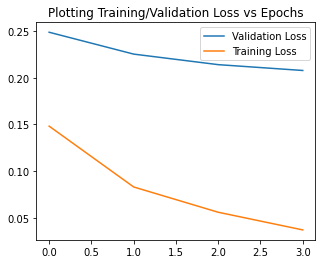

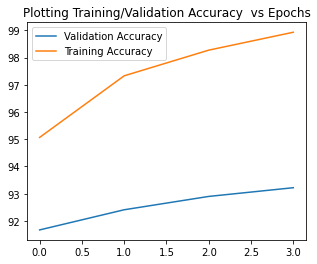

----------------------------------


In [ ]:
lr = [.01,.001,0.0001]
optimizers = ["SGD","Adam"]

for l  in lr:
  for op in optimizers:
    print(f"using lr:{l}&op:{op}")
    tst_hypr_googleNet = GoogleNet()
    # num_ftrs = model_resnet.fc.in_features
    tst_hypr_googleNet.fc = nn.Linear(1024, 10)
    tst_hypr_googleNet=tst_hypr_googleNet.to(get_default_device())
    tst_hypr_googleNet.goog_train_model(4,l,op)
    tst_hypr_googleNet.show_graph()
    print("----------------------------------")

using lr:0.01&op:Adam
Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
{'epoch': 1, 'Train_Loss': 1.2401155617114619, 'Train_Acc': 54.035, 'Val_Acc': 53.49, 'Val_Loss': 1.2582169035296034}
{'epoch': 2, 'Train_Loss': 1.1387805071581514, 'Train_Acc': 60.2725, 'Val_Acc': 58.9, 'Val_Loss': 1.1771948531917904}
{'epoch': 3, 'Train_Loss': 0.7790274982779581, 'Train_Acc': 72.3575, 'Val_Acc': 69.77, 'Val_Loss': 0.8574943123371347}
{'epoch': 4, 'Train_Loss': 0.7351367216477647, 'Train_Acc': 74.8875, 'Val_Acc': 70.74, 'Val_Loss': 0.8317895147619934}
Finished Training
Time taken for execution: 31.32 minutes


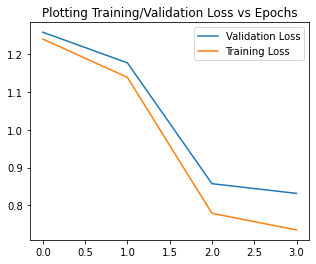

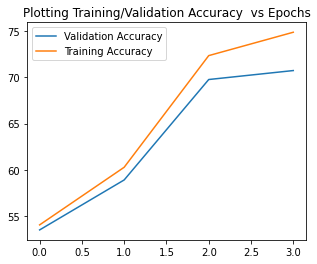

----------------------------------


In [ ]:
lr = [.01]
optimizers = ["Adam"]

for l  in lr:
  for op in optimizers:
    print(f"using lr:{l}&op:{op}")
    tst_hypr_googleNet = GoogleNet()
    # num_ftrs = model_resnet.fc.in_features
    tst_hypr_googleNet.fc = nn.Linear(1024, 10)
    tst_hypr_googleNet=tst_hypr_googleNet.to(get_default_device())
    tst_hypr_googleNet.goog_train_model(4,l,op)
    tst_hypr_googleNet.show_graph()
    print("----------------------------------")

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
{'epoch': 1, 'Train_Loss': 1.7401209400177002, 'Train_Acc': 35.19, 'Val_Acc': 35.04, 'Val_Loss': 1.7455207417948178}
{'epoch': 2, 'Train_Loss': 1.6341974850654601, 'Train_Acc': 40.58, 'Val_Acc': 39.54, 'Val_Loss': 1.6506910544995683}
{'epoch': 3, 'Train_Loss': 1.5659031383514403, 'Train_Acc': 43.065, 'Val_Acc': 42.1, 'Val_Loss': 1.5834134078254334}
{'epoch': 4, 'Train_Loss': 1.5411020215988158, 'Train_Acc': 44.495, 'Val_Acc': 43.08, 'Val_Loss': 1.5720441794623963}
{'epoch': 5, 'Train_Loss': 1.4810718903064728, 'Train_Acc': 46.055, 'Val_Acc': 44.43, 'Val_Loss': 1.5254827467397378}
Finished Training


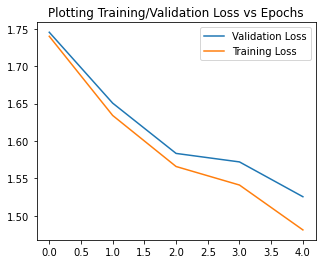

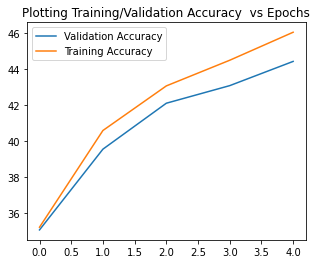

In [ ]:
#Just adding Linear dropout
model3 = Imagenet_model3()
model3=model3.to(get_default_device())
model3.train_model(5,0.01,"SGD")
model3.show_graph()

Show  Images in daatset

In [ ]:
class PujanNet(Basenet):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion):
        super().__init__()
        torch.manual_seed(5)
        self.stats = []
        self.epoch_number = 0
        self.shapes = False
    
        transform = transforms.Compose(
            [
                #transforms.Grayscale(num_output_channels=3), # with grayscale, overfitting slightly decreased, this should be the result of data augmentation, this is not converting all images to grayscale
                
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

        if data_set_name == "cifar_10":
            dataset = torchvision.datasets.CIFAR10(root=download_path, train=True, download=True, transform=transform)
            print('Length of Dataset ', len(dataset))

            train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_data_size, validation_data_size])
            print('Length of Train set ', len(train_dataset))
            print('Length of Val set ', len(val_dataset))
            self.trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
            self.valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

            testset = torchvision.datasets.CIFAR10(root=download_path, train=False, download=True, transform=transform)
            print('Length of Testset ', len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        self.criterion = criterion
        # input channel should be 3 for color image and 1 for grayscale
        self.conv1 = nn.Conv2d(3, 6, 3)
        # https://discuss.pytorch.org/t/example-on-how-to-use-batch-norm/216
        self.conv1_bn = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)
        # mat1 and mat2 shapes cannot be multiplied (4x576 and 400x120)
        # filter = 1, input shape for linear should be 6 * 6,
        # filter = 3, 5, input shape for linear should be 5 * 5
        # self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.dropout_2d = nn.Dropout2d()
        self.dropout_1d = nn.Dropout1d()

    def forward(self, x):
        if self.shapes:
            print("Initial x shape ", x.shape)
        # x = self.pool(F.relu(self.conv1(x)))
        # print("After conv1 and maxpool, x shape ", x.shape)

        # First layer
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = F.relu(x)
        if self.shapes:
            print('After conv1, shape of x is ', x.shape)
        x = self.pool(x)
        if self.shapes:
            print('After max pool 1, shape of x is ', x.shape)
        
        # dropout
        # x = self.dropout_2d(x)
        if self.shapes:
            print('Shape after dropout after conv layer 1 ', x.shape) 
        # Second layer
        # x = self.pool(F.relu(self.conv2(x)))
        # print("After conv2 and maxpool, x shape ", x.shape)

        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = F.relu(x)
        x = self.dropout_2d(x)
        if self.shapes:
            print('After conv2, shape of X is ', x.shape)
        x = self.pool(x)
        if self.shapes:
            print('After max pool 2, shape of x is ', x.shape)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        if self.shapes:
            print('After flatten, x shape ', x.shape)

        x = self.fc1(x)
        x = self.fc1_bn(x)
        x = F.relu(x)
        if self.shapes:
            print('After fc1, x shape ', x.shape)

        x = self.fc2(x)
        x = F.relu(x)
        if self.shapes:
            print('After fc2, x shape ', x.shape)
        x = self.fc3(x)
        if self.shapes:
            print('After fc3, x shape ', x.shape)
        return x


Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
{'epoch': 0, 'Train_Loss': 2.006696618843079, 'Train_Acc': 27.78, 'Val_Acc': 33.43, 'Val_Loss': 1.9679253473403349}
{'epoch': 1, 'Train_Loss': 1.9761597478866577, 'Train_Acc': 28.66, 'Val_Acc': 37.31, 'Val_Loss': 1.8838635986777628}
{'epoch': 2, 'Train_Loss': 1.992767588043213, 'Train_Acc': 28.81, 'Val_Acc': 40.57, 'Val_Loss': 1.8121617075743948}
{'epoch': 3, 'Train_Loss': 2.0300695779800413, 'Train_Acc': 28.2025, 'Val_Acc': 42.77, 'Val_Loss': 1.7565796800479767}
{'epoch': 4, 'Train_Loss': 2.0990071449279784, 'Train_Acc': 27.945, 'Val_Acc': 43.62, 'Val_Loss': 1.7327579502846784}
Finished Training


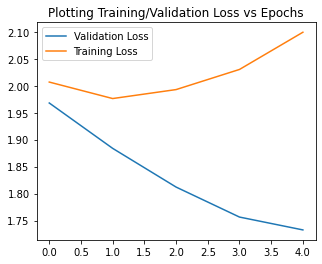

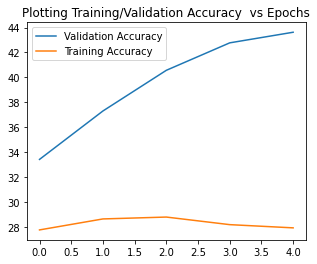

In [ ]:
criterion = nn.CrossEntropyLoss()
model_P = PujanNet(data_set_name = "cifar_10", batch_size = 64, download_path = "./data", 
                     train_data_size = 40000, validation_data_size = 10000, criterion = criterion)
model_P=model_P.to(get_default_device())
#def train(self,epochs,learning_rt=0.001,mm=0.9,optimizer_fn = "SGD"):
# model_P.train(5,0.001,"Adam")#0.0001
# model_P.show_graph()#'Train_Acc': 45.4075, 'Val_Acc': 45.31
model_P.train_model(5,0.001,"SGD")#0.0001
model_P.show_graph() # 'Train_Acc': 43.7425, 'Val_Acc': 43.8
# model_P.train_model(25,0.001,"Adam")#0.0001
# model_P.show_graph()#

{'epoch': 0, 'Train_Loss': 1.2293091514110566, 'Train_Acc': 56.11, 'Val_Acc': 52.59, 'Val_Loss': 1.338632341010121}
{'epoch': 1, 'Train_Loss': 1.198808199930191, 'Train_Acc': 57.4075, 'Val_Acc': 55.06, 'Val_Loss': 1.2883969299709455}
{'epoch': 2, 'Train_Loss': 1.194377490234375, 'Train_Acc': 57.4225, 'Val_Acc': 54.86, 'Val_Loss': 1.281893648278599}
{'epoch': 3, 'Train_Loss': 1.1873163534641267, 'Train_Acc': 57.975, 'Val_Acc': 54.15, 'Val_Loss': 1.2949131308272244}
{'epoch': 4, 'Train_Loss': 1.1953103123188018, 'Train_Acc': 57.19, 'Val_Acc': 54.26, 'Val_Loss': 1.2933300444112419}
{'epoch': 5, 'Train_Loss': 1.188926575422287, 'Train_Acc': 57.8975, 'Val_Acc': 54.48, 'Val_Loss': 1.2962515498883427}
{'epoch': 6, 'Train_Loss': 1.1864707315921783, 'Train_Acc': 57.735, 'Val_Acc': 54.22, 'Val_Loss': 1.2825414923052438}
{'epoch': 7, 'Train_Loss': 1.1848107779502868, 'Train_Acc': 57.885, 'Val_Acc': 53.89, 'Val_Loss': 1.3154965104005587}
{'epoch': 8, 'Train_Loss': 1.1694789078712464, 'Train_Acc': 

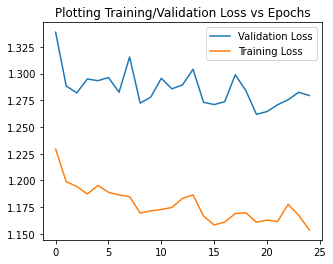

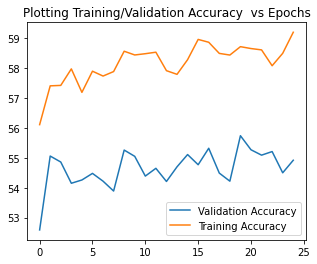

In [ ]:
model_P.train_model(25,0.001,"SGD")#0.0001
model_P.show_graph()

In [ ]:
#TEMP
class Imagenet_model4(Basenet):
    def __init__(self,dataset="CIFAR10",batch=15,path='./data',splitsize = .2):
        super().__init__()
        torch.manual_seed(42)
        self.shapes = False
        #CNN Layer 1
        self.conv1 = nn.Conv2d(3, 16, 3,padding = 1)
        #CNN Layer 2
        self.conv2 = nn.Conv2d(16, 32, 3,padding = 1)
        #CNN LAyer 3
        self.conv3 = nn.Conv2d(32, 64, 3,padding = 1)
        self.pool = nn.MaxPool2d(2, 2)

        #FCNN Layer 1
        self.fc1 = nn.Linear(64 * 4 * 4, 512)

        #FCNN Layer 2
        self.fc2 = nn.Linear(512, 64)

        #FCNN LAyer 3
        self.fc3 = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        

        # #Regularization Parameters
        # self.dropout2d = nn.Dropout2d()
        self.dropout1d = nn.Dropout1d(.4)

        self.criterion = None
        self.optimizer = None
        self.stats = []
        self.epoch = 0
        if dataset== "CIFAR10":
            batch_size = batch
            dataset = torchvision.datasets.CIFAR10(root=path, train=True,
                                                    download=True, transform=transform)
            val_size = int(len(dataset)*splitsize)
            train_size = len(dataset) - val_size
            train_set, valid_set = data.random_split(dataset, [train_size, val_size])
            self.train_set = train_set
            self.trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Training Size :",len(train_set))
            
            self.valloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                                      shuffle=True, num_workers=2)
            print("Validation Size :",len(valid_set))
            testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                                  download=True, transform=transform)
            print("Testing Size :",len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat',
                      'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    def forward(self, x):

        #CNN Layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.dropout2d(x)

        #CNN Layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        #CNN Layer 3
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)


        # x = self.dropout2d(x)

        # flatten all dimensions except batch
        # x = torch.flatten(x, 1)
        x = x.view(-1,64*4*4) 
        #FCNN Layer 1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1d(x)

        #FCNN Layer 2
        x = self.fc2(x)
        # x = self.batchnorm3(x)
        x = F.relu(x)
        x = self.dropout1d(x)
        #FCNN Layer 3
        x = self.fc3(x)
        # x = self.batchnorm3(x)
        x = F.relu(x)
        x = self.dropout1d(x)

        #LAst Linear Layer
        x = self.fc3(x)
        # x = self.softmax(x)
        return x
# !nvidia-smi
temp = Imagenet_model3().to(get_default_device())
summary(temp, (3, 32, 32))

Files already downloaded and verified
Training Size : 40000
Validation Size : 10000
Files already downloaded and verified
Testing Size : 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
         Dropout2d-5             [-1, 16, 5, 5]               0
            Linear-6                  [-1, 120]          48,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
           Softmax-9                   [-1, 10]               0
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 